# ADA Project: Food for thought

This notebook contains the full analysis of our project. It aims at answering the following research questions:

- Data exploration: What is the diabetes and obesity prevalence among the adult population in London? How are those correlated? And what are the food patterns that are the most correlated with nutrition-related diseases?

- What is the average diet of a Londoner?

- Can we compute a healthy diet score for each borough?
 * Method 0: We use the WHO recommendations and calculate how much the boroughs' diet differ for each criteria.
 * Method 1: We fit a linear regression on the overweight and obesity data with their most correlated food nutrients.
 * Method 2: We fit a linear regression on the overweight and obesity data with the most consumed food categories.

*We min-max scale each score between 0 and 1. To validate each score, we calculate its Spearman correlation coefficient with the diabetes prevalence and select the best one.*

- How does this score relate to the economical situation of each borough?

*We fit a linear regression to predict a healthy area from the earnings, the child poverty as well as the food expenditure.*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import diagnostic
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.model_selection import cross_validate
from pywaffle import Waffle
import numpy as np, scipy.stats as st

In [2]:
pd.options.display.max_columns = None

### Loading and wrangling data

In [3]:
PATH = './data/'

GROCERY_WARD = 'year_osward_grocery.csv'
GROCERY_BOROUGH = 'year_borough_grocery.csv'

DIABETES_WARD = 'diabetes_estimates_osward_2016.csv'
OBESITY_BOROUGH = 'london_obesity_borough_2012.csv'
CHILD_OBESITY_WARD = 'child_obesity_london_ward_2013-2014.csv'

MAPPING_BOROUGH_WARD = 'Mapping-template-london-ward-map-2018.xls'
MAPPING_CODE_BOROUGH = 'Mapping-template-for-London-boroughs.xls'

BOUNDARIES_BOROUGH = 'statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp'

CONSUMER_EXPENDITURE_BOROUGH = 'detailed-borough-base.xls'
CHILDREN_POVERTY_BOROUGH = 'children-in-poverty.xls'
EARNINGS_BOROUGH = 'earnings-residence-borough.xlsx'

#### Grocery data

In [4]:
groceries_borough = pd.read_csv(PATH + GROCERY_BOROUGH, sep = ',', header = 0)
groceries_ward = pd.read_csv(PATH + GROCERY_WARD, sep = ',', header = 0)

# Consider only the areas with a representativeness_norm > 10%
groceries_borough = groceries_borough[groceries_borough['representativeness_norm'] >= 0.1]
groceries_ward = groceries_ward[groceries_ward['representativeness_norm'] >= 0.1]

#### Ward to borough mapping

In [5]:
mapping_ward_to_borough = pd.read_excel(PATH + MAPPING_BOROUGH_WARD, sheet_name = 'Ward Thematic Map',usecols = [0, 1, 2],
                                        names = ['Ward Code', 'Ward name', 'Borough name'])
mapping_code_to_borough = pd.read_excel(PATH + MAPPING_CODE_BOROUGH, sheet_name = 'Borough Thematic Map',usecols = [1, 2],
                                       names = ['Borough Code', 'Borough name'])
mapping_ward_to_borough = mapping_ward_to_borough.merge(mapping_code_to_borough, on = 'Borough name')
mapping_ward_to_borough = mapping_ward_to_borough.drop(columns = ['Ward name', 'Borough name'])

#### Health data

Some of the data (diabetes and child obesity) are only available for borough, thus we average all wards part of a same borough and map the data to the corresponding borough.

In [6]:
# Diabetes
diabetes_ward = pd.read_csv(PATH + DIABETES_WARD, sep = ',', header = 0)
diabetes_ward = diabetes_ward.merge(mapping_ward_to_borough, left_on = 'area_id', right_on = 'Ward Code')
diabetes_ward = diabetes_ward.drop(columns = ['Ward Code'])
diabetes_borough = diabetes_ward.groupby(['Borough Code'], as_index = False).mean()

In [7]:
# Obesity
obesity_borough = pd.read_csv(PATH + OBESITY_BOROUGH, sep = ',', header = 0)

# Calculate the percentage of underweight people
obesity_borough['f_underweight'] = 100 - obesity_borough[['f_healthy_weight', 'f_overweight', 'f_obese']].sum(axis=1)

In [8]:
# Child obesity
child_obesity_ward = pd.read_csv(PATH + CHILD_OBESITY_WARD, sep = ',', header = 0)
to_drop = child_obesity_ward[ (child_obesity_ward['prevalence_overweight_reception'] == 'na')
                             | (child_obesity_ward['prevalence_overweight_y6'] == 'na')
                            | (child_obesity_ward['prevalence_obese_reception'] == 'na')
                            | (child_obesity_ward['prevalence_obese_y6'] == 'na')].index
child_obesity_ward.drop(to_drop , inplace=True)
child_obesity_ward = child_obesity_ward.merge(mapping_ward_to_borough, left_on = 'area_id', right_on = 'Ward Code')
child_obesity_ward = child_obesity_ward.drop(columns = ['Ward Code'])
child_obesity_ward = child_obesity_ward.astype({'number_reception_measured': 'float64',
          'number_y6_measured': 'float64',
          'prevalence_overweight_reception': 'float64',
          'prevalence_overweight_y6': 'float64',
          'prevalence_obese_reception': 'float64',
          'prevalence_obese_y6': 'float64'})
child_obesity_borough = child_obesity_ward.groupby(['Borough Code'], as_index = False).mean()

Merge data for wards

In [9]:
merged_ward = pd.merge(diabetes_ward, groceries_ward, how = 'inner', left_index = False, on='area_id')
print(('Final dataset has {:.0f} wards.').format(len(merged_ward)))
merged_ward.head()

Final dataset has 526 wards.


,area_id,gp_patients,gp_patients_diabetes,estimated_diabetes_prevalence,Borough Code,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,volume_perc2.5,volume_perc25,volume_perc50,volume_perc75,volume_perc97.5,volume_std,volume_ci95,fat,fat_perc2.5,fat_perc25,fat_perc50,fat_perc75,fat_perc97.5,fat_std,fat_ci95,saturate,saturate_perc2.5,saturate_perc25,saturate_perc50,saturate_perc75,saturate_perc97.5,saturate_std,saturate_ci95,salt,salt_perc2.5,salt_perc25,salt_perc50,salt_perc75,salt_perc97.5,salt_std,salt_ci95,sugar,sugar_perc2.5,sugar_perc25,sugar_perc50,sugar_perc75,sugar_perc97.5,sugar_std,sugar_ci95,protein,protein_perc2.5,protein_perc25,protein_perc50,protein_perc75,protein_perc97.5,protein_std,protein_ci95,carb,carb_perc2.5,carb_perc25,carb_perc50,carb_perc75,carb_perc97.5,carb_std,carb_ci95,fibre,fibre_perc2.5,fibre_perc25,fibre_perc50,fibre_perc75,fibre_perc97.5,fibre_std,fibre_ci95,alcohol,alcohol_perc2.5,alcohol_perc25,alcohol_perc50,alcohol_perc75,alcohol_perc97.5,alcohol_std,alcohol_ci95,energy_fat,energy_fat_perc2.5,energy_fat_perc25,energy_fat_perc50,energy_fat_perc75,energy_fat_perc97.5,energy_fat_std,energy_fat_ci95,energy_saturate,energy_saturate_perc2.5,energy_saturate_perc25,energy_saturate_perc50,energy_saturate_perc75,energy_saturate_perc97.5,energy_saturate_std,energy_saturate_ci95,energy_sugar,energy_sugar_perc2.5,energy_sugar_perc25,energy_sugar_perc50,energy_sugar_perc75,energy_sugar_perc97.5,energy_sugar_std,energy_sugar_ci95,energy_protein,energy_protein_perc2.5,energy_protein_perc25,energy_protein_perc50,energy_protein_perc75,energy_protein_perc97.5,energy_protein_std,energy_protein_ci95,energy_carb,energy_carb_perc2.5,energy_carb_perc25,energy_carb_perc50,energy_carb_perc75,energy_carb_perc97.5,energy_carb_std,energy_carb_ci95,energy_fibre,energy_fibre_perc2.5,energy_fibre_perc25,energy_fibre_perc50,energy_fibre_perc75,energy_fibre_perc97.5,energy_fibre_std,energy_fibre_ci95,energy_alcohol,energy_alcohol_perc2.5,energy_alcohol_perc25,energy_alcohol_perc50,energy_alcohol_perc75,energy_alcohol_perc97.5,energy_alcohol_std,energy_alcohol_ci95,energy_tot,energy_tot_perc2.5,energy_tot_perc25,energy_tot_perc50,energy_tot_perc75,energy_tot_perc97.5,energy_tot_std,energy_tot_ci95,f_energy_fat,f_energy_saturate,f_energy_sugar,f_energy_protein,f_energy_carb,f_energy_fibre,f_energy_alcohol,energy_density,h_nutrients_weight,h_nutrients_weight_norm,h_nutrients_calories,h_nutrients_calories_norm,f_beer,f_dairy,f_eggs,f_fats_oils,f_fish,f_fruit_veg,f_grains,f_meat_red,f_poultry,f_readymade,f_sauces,f_soft_drinks,f_spirits,f_sweets,f_tea_coffee,f_water,f_wine,f_dairy_weight,f_eggs_weight,f_fats_oils_weight,f_fish_weight,f_fruit_veg_weight,f_grains_weight,f_meat_red_weight,f_poultry_weight,f_readymade_weight,f_sauces_weight,f_sweets_weight,h_items,h_items_norm,h_items_weight,h_items_weight_norm,representativeness_norm,transaction_days,num_transactions,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E05000026,13136,1068,8.1,E09000002,449.535137,32.5,166.4,300.0,500.0,1500.0,771.349423,3.716832,125.960833,11.00,45.000,90.0,200.0,340.8,114.892118,1.127239,9.488797,0.0,0.2,2.4,14.1,50.5,15.119655,0.057529,3.693721,0.0,0.1,0.8,4.3,21.0,6.714925,0.025550,0.583240,0.0,0.01,0.20,0.80,2.4,2.239420,0.008521,10.966213,0.0,1.4,4.4,11.8,58.5,16.636405,0.063300,4.977560,0.0,0.4,2.8,7.6,23.4,6.156284,0.023424,19.381951,0.0,0.3,8.2,32.2,73.5,23.859315,0.090782,1.564721,0.0,0.0,1.0,2.2,7.3,2.323645,0.008841,0.198172,0.0,0.0,0.0,0.0,0.0,1.692997,0.006442,85.399176,0.0,1.8,21.6,126.9,454.5,136.076899,0.517759,33.243489,0.0,0.9,7.2,38.7,189.0,60.434321,0.229946,43.864852,0.0,5.6,17.6,47.2,234.0,66.545619,0.253199,19.910240,0.0,1.6,11.2,30.4,93.6,24.625135,0.093696,77.527804,0.0,1.2,32.8,128.8,294.0,95.437261,0.363129,2.890336,0.0,0.0,1.6,4.4,14.4,4.436731,0.016881,1.387201,0.0,0.0,0.0,0.0,0.0,11.850977,0.045092,187.114757,0.0,41.

Merge data for boroughs

In [10]:
merged = pd.merge(groceries_borough, obesity_borough, how = 'inner', left_index = False, left_on='area_id',
                         right_on = 'oslaua')
merged = pd.merge(merged, child_obesity_borough, how = 'inner', left_index = False, left_on='area_id',
                         right_on = 'Borough Code')
merged_borough = pd.merge(merged, diabetes_borough, how = 'inner', left_index = False, left_on='area_id',
                         right_on = 'Borough Code')
print(('Final dataset has {:.0f} boroughs.').format(len(merged_borough)))
merged_borough.head()

Final dataset has 26 boroughs.


,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,volume_perc2.5,volume_perc25,volume_perc50,volume_perc75,volume_perc97.5,volume_std,volume_ci95,fat,fat_perc2.5,fat_perc25,fat_perc50,fat_perc75,fat_perc97.5,fat_std,fat_ci95,saturate,saturate_perc2.5,saturate_perc25,saturate_perc50,saturate_perc75,saturate_perc97.5,saturate_std,saturate_ci95,salt,salt_perc2.5,salt_perc25,salt_perc50,salt_perc75,salt_perc97.5,salt_std,salt_ci95,sugar,sugar_perc2.5,sugar_perc25,sugar_perc50,sugar_perc75,sugar_perc97.5,sugar_std,sugar_ci95,protein,protein_perc2.5,protein_perc25,protein_perc50,protein_perc75,protein_perc97.5,protein_std,protein_ci95,carb,carb_perc2.5,carb_perc25,carb_perc50,carb_perc75,carb_perc97.5,carb_std,carb_ci95,fibre,fibre_perc2.5,fibre_perc25,fibre_perc50,fibre_perc75,fibre_perc97.5,fibre_std,fibre_ci95,alcohol,alcohol_perc2.5,alcohol_perc25,alcohol_perc50,alcohol_perc75,alcohol_perc97.5,alcohol_std,alcohol_ci95,energy_fat,energy_fat_perc2.5,energy_fat_perc25,energy_fat_perc50,energy_fat_perc75,energy_fat_perc97.5,energy_fat_std,energy_fat_ci95,energy_saturate,energy_saturate_perc2.5,energy_saturate_perc25,energy_saturate_perc50,energy_saturate_perc75,energy_saturate_perc97.5,energy_saturate_std,energy_saturate_ci95,energy_sugar,energy_sugar_perc2.5,energy_sugar_perc25,energy_sugar_perc50,energy_sugar_perc75,energy_sugar_perc97.5,energy_sugar_std,energy_sugar_ci95,energy_protein,energy_protein_perc2.5,energy_protein_perc25,energy_protein_perc50,energy_protein_perc75,energy_protein_perc97.5,energy_protein_std,energy_protein_ci95,energy_carb,energy_carb_perc2.5,energy_carb_perc25,energy_carb_perc50,energy_carb_perc75,energy_carb_perc97.5,energy_carb_std,energy_carb_ci95,energy_fibre,energy_fibre_perc2.5,energy_fibre_perc25,energy_fibre_perc50,energy_fibre_perc75,energy_fibre_perc97.5,energy_fibre_std,energy_fibre_ci95,energy_alcohol,energy_alcohol_perc2.5,energy_alcohol_perc25,energy_alcohol_perc50,energy_alcohol_perc75,energy_alcohol_perc97.5,energy_alcohol_std,energy_alcohol_ci95,energy_tot,energy_tot_perc2.5,energy_tot_perc25,energy_tot_perc50,energy_tot_perc75,energy_tot_perc97.5,energy_tot_std,energy_tot_ci95,f_energy_fat,f_energy_saturate,f_energy_sugar,f_energy_protein,f_energy_carb,f_energy_fibre,f_energy_alcohol,energy_density,h_nutrients_weight,h_nutrients_weight_norm,h_nutrients_calories,h_nutrients_calories_norm,f_beer,f_dairy,f_eggs,f_fats_oils,f_fish,f_fruit_veg,f_grains,f_meat_red,f_poultry,f_readymade,f_sauces,f_soft_drinks,f_spirits,f_sweets,f_tea_coffee,f_water,f_wine,f_dairy_weight,f_eggs_weight,f_fats_oils_weight,f_fish_weight,f_fruit_veg_weight,f_grains_weight,f_meat_red_weight,f_poultry_weight,f_readymade_weight,f_sauces_weight,f_sweets_weight,h_items,h_items_norm,h_items_weight,h_items_weight_norm,representativeness_norm,transaction_days,num_transactions,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km,oslaua,f_healthy_weight,f_overweight,f_obese,weighted_sample,f_underweight,Borough Code_x,number_reception_measured,number_y6_measured,prevalence_overweight_reception,prevalence_overweight_y6,prevalence_obese_reception,prevalence_obese_y6,Borough Code_y,gp_patients,gp_patients_diabetes,estimated_diabetes_prevalence
0,E09000002,421.304125,32.5,165.6,300.0,500.0,1500.0,597.994271,0.828993,122.341294,11.0,47.1,90.0,175.0,340.8,115.859833,0.351870,9.209959,0.0,0.2,2.4,13.9,48.2,14.478662,0.016131,3.596834,0.0,0.1,0.8,4.1,20.5,6.466539,0.007205,0.603081,0.0,0.03,0.20,0.80,2.4,2.168270,0.002416,10.793244,0.0,1.3,4.1,11.8,58.5,16.635331,0.018534,5.193872,0.0,0.4,3.0,7.9,23.5,6.274192,0.006990,19.784988,0.0,0.4,8.7,33.6,75.3,24.192629,0.026954,1.590335,0.0,0.0,1.0,2.2,7.5,2.451484,0.002731,0.202540,0.0,0.0,0.0,0.0,0.00,1.767156,0.001969,82.889630,0.0,1.8,21.6,125.1,433.8,130.307956,0.145182,32.371503,0.0,0.9,7.2,36.9,184.5,58.198855,0.064842,43.172978,0.0,5.2,16.4,47.2,234.0,66.541322,0.074136,20.775

#### Economic data

In [11]:
# Child poverty
children_poverty = pd.read_excel(PATH+CHILDREN_POVERTY_BOROUGH, sheet_name = '2015',usecols = [0, 5],
                                        names = ['area_id', 'child_poverty'])
children_poverty = children_poverty.loc[21:53]
children_poverty = children_poverty.astype({'child_poverty': 'float64'})

In [12]:
# Earnings
earnings = pd.read_excel(PATH+EARNINGS_BOROUGH, sheet_name = 'Full-time, Weekly',usecols = [1, 28],
                                       names = ['Borough name', 'earnings'], na_values=['#'])
earnings = earnings.loc[2:34]
earnings = earnings.astype({'earnings': 'float64'})

In [13]:
# Consumer expenditure
consumer_expenditure = pd.read_excel(PATH+CONSUMER_EXPENDITURE_BOROUGH, sheet_name = 'Greater London',usecols = [0, 1, 17],
                                        names = ['Borough name', 'type', 'expenditure'], skiprows=[0, 1, 2])
consumer_expenditure.dropna(inplace=True)
consumer_expenditure.sort_values(by=['Borough name'], inplace=True)
consumer_expenditure = consumer_expenditure.pivot_table(values='expenditure', index='Borough name', columns='type')

# Transform the data in order to have percentages for each type
consumer_expenditure = consumer_expenditure.transform(lambda x: (x * 100/ x.sum()), axis=1)

### RQ1 (data exploration): What is the diabetes and obesity prevalence among the adult population in London? How are those correlated? And what are the food patterns that are the most correlated with nutrition-related diseases?

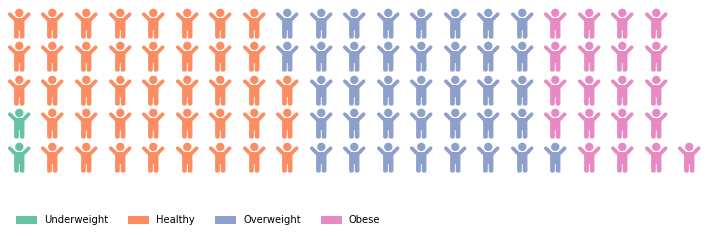

In [14]:
data = obesity_borough.mean().loc[["f_underweight", "f_healthy_weight", "f_overweight", "f_obese"]]
fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    values= data,
    labels=['Underweight', 'Healthy', 'Overweight', 'Obese'],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0},
    icons='child',
    font_size=30,
    figsize=(10, 5)
)
plt.savefig("figures/obesity.svg", pad_inches=0, bbox_inches = 'tight')

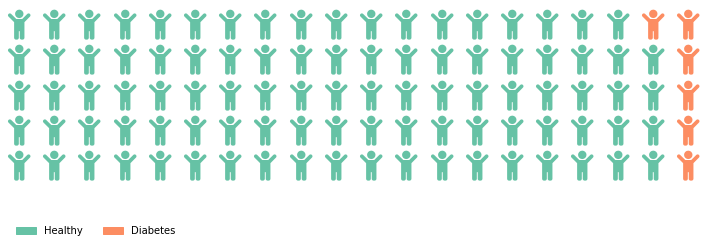

In [15]:
diabetes_prev = diabetes_borough.mean().loc[["estimated_diabetes_prevalence"]]["estimated_diabetes_prevalence"]
fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    values= [100 - diabetes_prev, diabetes_prev],
    labels=['Healthy', 'Diabetes'],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0},
    icons='child',
    font_size=30,
    figsize=(10, 5)
)
plt.savefig("figures/diabetes.svg", pad_inches=0, bbox_inches = 'tight')

In [16]:
child_obesity_borough.describe()

,number_reception_measured,number_y6_measured,prevalence_overweight_reception,prevalence_overweight_y6,prevalence_obese_reception,prevalence_obese_y6
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,435.907551,350.256430,0.224514,0.363181,0.102680,0.215964
std,125.004798,95.316929,0.024019,0.040257,0.019164,0.034629
min,177.333333,162.333333,0.165666,0.240736,0.057001,0.116212
25%,359.582589,279.643382,0.210794,0.345689,0.092973,0.198592
50%,441.382895,367.609211,0.228190,0.369987,0.103811,0.220607
75%,519.357143,427.089052,0.236771,0.390932,0.116924,0.239654
max,661.600000,536.750000,0.262066,0.415315,0.135017,0.261622


In [17]:
diabetes_borough.describe()

,gp_patients,gp_patients_diabetes,estimated_diabetes_prevalence
count,28.000000,28.000000,28.000000
mean,12125.690796,759.500888,6.231147
std,2066.223815,239.729819,1.483826
min,7846.611111,328.722222,3.911111
25%,10519.189286,605.895833,5.053125
50%,12275.627778,757.877709,6.349206
75%,13432.383987,925.208333,7.523160
max,15474.750000,1254.200000,9.300000


In [18]:
obesity_borough.describe()

,f_healthy_weight,f_overweight,f_obese,weighted_sample,f_underweight
count,33.000000,33.000000,33.000000,33.000000,33.000000
mean,41.278788,37.351515,19.793939,597.212121,1.575758
std,5.893734,3.304365,4.983782,162.569362,1.162441
min,32.600000,30.500000,11.200000,20.000000,0.100000
25%,36.500000,34.900000,15.900000,523.000000,0.600000
50%,41.300000,37.500000,20.500000,606.000000,1.400000
75%,45.100000,40.200000,23.000000,711.000000,2.200000
max,52.800000,43.800000,31.600000,862.000000,4.600000


We check whether there are some correlations between the indicators

In [19]:
def correlation_heatmap(df):
    mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
    heatmap = sns.heatmap(df.corr(method='spearman'), vmin=-1, vmax=1, mask = mask, annot=True)
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

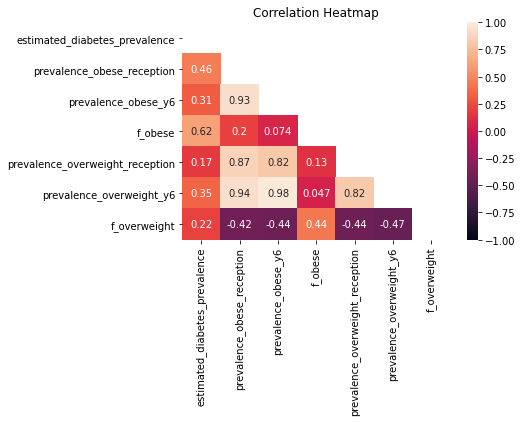

In [20]:
indicators = ['estimated_diabetes_prevalence', 'prevalence_obese_reception', 'prevalence_obese_y6','f_obese', 'prevalence_overweight_reception', 'prevalence_overweight_y6', 'f_overweight']
df = merged_borough[indicators]
correlation_heatmap(df)

We check if diabetes and overweight are correlated with any 'types' food habits.

In [21]:
# We partition 'types' of food habits
energy_nutrients = ['energy_fat', 'energy_saturate', 'energy_sugar', 'energy_protein', 'energy_carb', 
                    'energy_fibre', 'energy_alcohol']
f_food_categories = ['f_beer', 'f_dairy', 'f_eggs', 'f_fats_oils', 'f_fish', 'f_fruit_veg', 'f_grains',
                   'f_meat_red', 'f_poultry', 'f_readymade', 'f_sauces', 'f_soft_drinks', 'f_spirits',
                   'f_sweets', 'f_tea_coffee', 'f_water', 'f_wine']
weight_categories = ['f_dairy_weight', 'f_eggs_weight', 'f_fats_oils_weight', 'f_fish_weight',
                    'f_fruit_veg_weight', 'f_grains_weight', 'f_meat_red_weight', 'f_poultry_weight',
                    'f_readymade_weight', 'f_sauces_weight',
                   'f_sweets_weight']

features = energy_nutrients + f_food_categories
indicators = ['estimated_diabetes_prevalence', 'f_overweight']

We plot some correlations between features and health indicators just for the sake of visualization.
Here we only look at energy_nutrients, f_food_categories as features and estimated_diabetes_prevalence and f_overweight as health indicators to represent the global trend.

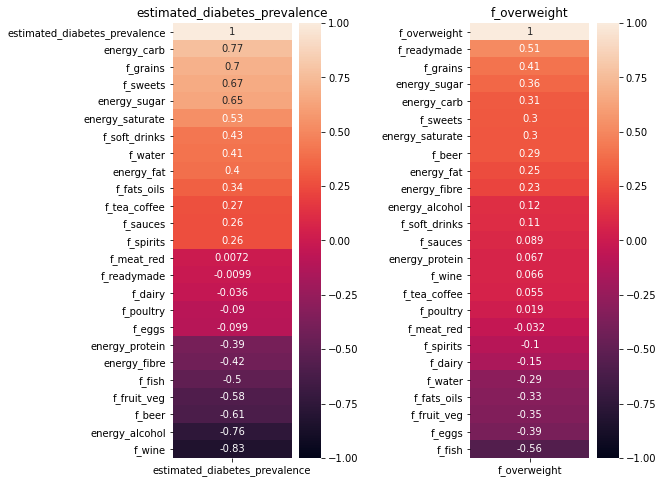

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(8, 8))

for i, ind in enumerate(indicators):
    labels = features.copy()
    labels.append(ind)
    df = merged_borough[labels]
    heatmap = sns.heatmap(df.corr(method='spearman')[[ind]].sort_values(by = ind, ascending=False), vmin=-1, vmax=1, annot=True, ax=axs[i])
    heatmap.set_title(ind, fontdict={'fontsize':12})
    
plt.subplots_adjust(wspace=1)

### RQ2: What is the average diet of a Londoner?

Inspect nutrient and category repartition in average diet

In [23]:
average_nutrients = pd.DataFrame(groceries_ward.mean(axis = 0)[energy_nutrients], columns = ['value'])
average_categories = pd.DataFrame(groceries_ward.mean(axis = 0)[f_food_categories], columns = ['value'])
average_weight_categories = pd.DataFrame(groceries_ward.mean(axis = 0)[weight_categories], columns = ['value'])

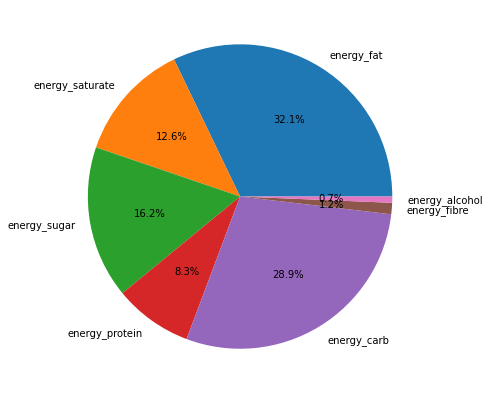

In [24]:
plot = average_nutrients.plot.pie(y='value', figsize=(7,7), autopct='%1.1f%%', legend=False)
plot.set_ylabel('');

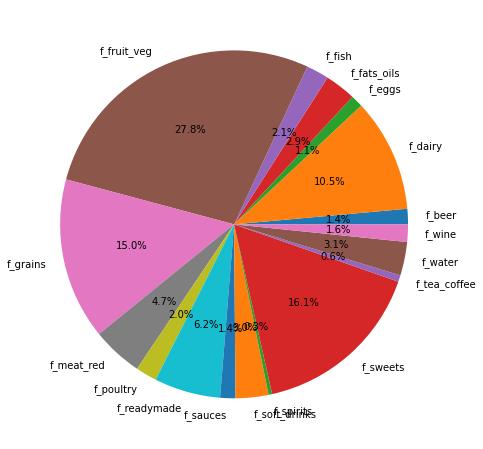

In [25]:
plot = average_categories.plot.pie(y='value', figsize=(8, 8), autopct='%1.1f%%', legend=False)
plot.set_ylabel('');

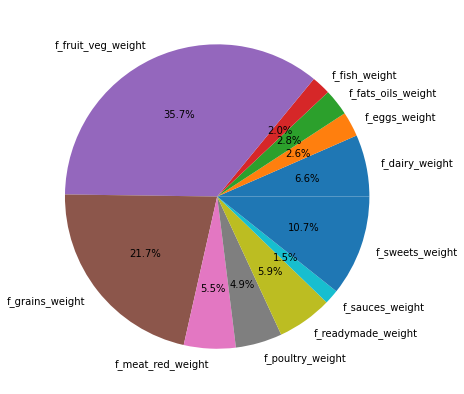

In [26]:
plot = average_weight_categories.plot.pie(y='value', figsize=(7,7), autopct='%1.1f%%', legend=False)
plot.set_ylabel('');

### RQ3: Compute a diet score

#### Method 0: Compare each area's diet to the WHO recommendations

We compute 3 criterias that make a diet healthy and that are either 0 or 1 depending on if they are fulfilled or not: fat criteria (< 30% of total energy intake), saturated fat criteria (< 10% of total energy intake) and sugars criteria (< 10% of total energy intake). We obtain a final score between 0 and 3, out of 3.

In [27]:
# Total fat should not exceed 30% of total energy intake
groceries_borough['WHO_totalfat'] = 0
groceries_borough.loc[(groceries_borough['energy_fat'] <= 0.3*groceries_borough['energy_tot']), 'WHO_totalfat'] = 1
print(('{:.0f}% of the boroughs satisfy the fat criterion.').format(groceries_borough['WHO_totalfat'].sum()/groceries_borough.shape[0]*100))

0% of the boroughs satisfy the fat criterion.


In [28]:
# Intake of saturated fats should be less than 10% of total energy intake
groceries_borough['WHO_saturatedfat'] = 0
groceries_borough.loc[(groceries_borough['energy_saturate'] <= 0.1*groceries_borough['energy_tot']), 'WHO_saturatedfat'] = 1
print(('{:.0f}% of the boroughs satisfy the saturated fat criterion.').format(groceries_borough['WHO_saturatedfat'].sum()/groceries_borough.shape[0]*100))

0% of the boroughs satisfy the saturated fat criterion.


In [29]:
# Intake of free sugars should be less than 10% of total energy intake
groceries_borough['WHO_freesugars'] = 0
groceries_borough.loc[(groceries_borough['energy_sugar'] <= 0.1*groceries_borough['energy_sugar']), 'WHO_freesugars'] = 1
print(('{:.0f}% of the boroughs satisfy the sugar criterion.').format(groceries_borough['WHO_freesugars'].sum()/groceries_borough.shape[0]*100))

0% of the boroughs satisfy the sugar criterion.


We can observe that none of the London boroughs fulfill the WHO recommendations. To be a little less strict, we instead compute the difference between each area's criteria with the recommended one.

In [30]:
groceries_borough['WHO_saturatedfat'] = groceries_borough.apply(lambda x: x['energy_fat']-0.3*x['energy_tot'], axis = 1)
groceries_borough['WHO_totalfat'] = groceries_borough.apply(lambda x: x['energy_saturate']-0.1*x['energy_tot'], axis = 1)
groceries_borough['WHO_freesugars'] = groceries_borough.apply(lambda x: x['energy_sugar']-0.1*x['energy_tot'], axis = 1)
groceries_borough['score0'] = groceries_borough['WHO_saturatedfat'] + groceries_borough['WHO_totalfat'] + groceries_borough['WHO_freesugars']
scaler = MinMaxScaler()
groceries_borough['score0'] = 1 - scaler.fit_transform(groceries_borough[['score0']].values.reshape(-1,1))

In [31]:
print(('Average/Min/Max excess of fat: {:.2f}% {:.2f}% {:.2f}%').format(groceries_borough['WHO_totalfat'].mean(), groceries_borough['WHO_totalfat'].min(),
     groceries_borough['WHO_totalfat'].max()))
print(('Average/Min/Max excess of saturated fat: {:.2f}% {:.2f}% {:.2f}%').format(groceries_borough['WHO_saturatedfat'].mean(),
      groceries_borough['WHO_saturatedfat'].min(), groceries_borough['WHO_saturatedfat'].max()))
print(('Average/Min/Max excess of sugar: {:.2f}% {:.2f}% {:.2f}%').format(groceries_borough['WHO_freesugars'].mean(),
      groceries_borough['WHO_freesugars'].min(), groceries_borough['WHO_freesugars'].max()))

Average/Min/Max excess of fat: 13.97% 12.78% 15.13%
Average/Min/Max excess of saturated fat: 27.13% 25.20% 29.41%
Average/Min/Max excess of sugar: 21.85% 17.84% 26.79%


#### Method 1 : fit a linear regression on the overweight and obesity data with the highest correlated energy_nutrients features

In [32]:
indicators = ['prevalence_obese_reception', 'prevalence_obese_y6', 'f_obese', 'prevalence_overweight_reception',
              'prevalence_overweight_y6', 'f_overweight']
energy_nutrients += ['energy_tot', 'h_nutrients_calories']

In [33]:
for i in indicators:
    correlation = pd.DataFrame(columns = ['feature', 'R', 'p_value'])
    for f in energy_nutrients:
        corr = stats.spearmanr(merged_borough[i], merged_borough[f])
        corr_data = pd.DataFrame([[f, corr[0], corr[1]]], columns = ['feature', 'R', 'p_value'])
        correlation = correlation.append(corr_data, ignore_index = True)
    sig_features = correlation[correlation['p_value'] < 0.05]
    print(i, "\n", sig_features, "\n")

prevalence_obese_reception 
                 feature         R   p_value
4           energy_carb  0.388718  0.049697
5          energy_fibre -0.680000  0.000133
6        energy_alcohol -0.630085  0.000561
8  h_nutrients_calories -0.496068  0.009955 

prevalence_obese_y6 
                 feature         R   p_value
5          energy_fibre -0.699829  0.000069
6        energy_alcohol -0.536410  0.004729
8  h_nutrients_calories -0.416752  0.034178 

f_obese 
                 feature         R   p_value
2          energy_sugar  0.592681  0.001420
4           energy_carb  0.667579  0.000195
7            energy_tot  0.592681  0.001420
8  h_nutrients_calories -0.521204  0.006327 

prevalence_overweight_reception 
         feature         R   p_value
5  energy_fibre -0.602051  0.001137 

prevalence_overweight_y6 
                 feature         R   p_value
5          energy_fibre -0.684786  0.000114
6        energy_alcohol -0.537094  0.004666
8  h_nutrients_calories -0.413333  0.035831 

f_ov

We only select the features with a statistically significant Spearman rank correlation (p < 0.05) with almost two indicators. As we have a small dataset, we want a very few but very relevant features for our model. We thus select the carbohydrates energy, the fibre energy and the entropy of nutrients energy.

In [34]:
features = ['energy_carb', 'energy_fibre', 'h_nutrients_calories']

To find the weights of each feature, we fit a regressor that we train with a Stochastic Gradient Descent algorithm. We cross validate to find the optimal hyper-parameters and we select the model who has the highest validation $R^2$.

In [35]:
def find_weights(merged, label):
    X = merged[features]
    y = merged[label]
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    hyperparams = {'reg':[0.1, 0.01, 0.001, 0.0001], 'learning_rate':[0.1, 0.05, 0.01]}
    scenarios = []
    for lr in hyperparams['learning_rate']:
        for r in hyperparams['reg']:
            scores = cross_validate(SGDRegressor(alpha = r, eta0 = lr),X, y = y, cv = 3,
                             scoring=('explained_variance', 'neg_mean_squared_error', 'r2'))
            scenario = {'learning_rate':lr, 'regularizer':r,
                        'MSE': scores['test_neg_mean_squared_error'],
                        'Explained variance': scores['test_explained_variance'],
                       'r2' : scores['test_r2']}
            scenarios.append(scenario)

    best = np.argmax([np.mean(s['r2']) for s in scenarios])

    reg_opt = scenarios[best]['regularizer']
    lr_opt = scenarios[best]['learning_rate']
    model_opt = SGDRegressor(eta0 = lr_opt, alpha = reg_opt)
    model_opt.fit(X,y)
    r2 = model_opt.score(X, y)
    train_error = np.mean((model_opt.predict(X)-y)**2)
    prediction = model_opt.predict(X)
    print(label)
    print(("Training error : {:.6f}, R2 : {:.6f}").
          format(train_error, r2))
    return model_opt.coef_, prediction

In [36]:
weights = pd.DataFrame(index = features, columns = indicators)

for label in indicators:
    weights[label],_ = find_weights(merged_borough, label)

prevalence_obese_reception
Training error : 0.000152, R2 : 0.466520
prevalence_obese_y6
Training error : 0.000517, R2 : 0.517857
f_obese
Training error : 10.819650, R2 : 0.501605
prevalence_overweight_reception
Training error : 0.000253, R2 : 0.400504
prevalence_overweight_y6
Training error : 0.000770, R2 : 0.455983
f_overweight
Training error : 7.338273, R2 : 0.237959


For the final weights, we average the weights for all the health indicators.

In [37]:
weights = weights.mean(axis = 1)

The score is simply the weighted sum of the selected features. We then scale it to obtain a value between 0 and 1.

In [38]:
def score(area):
    df = area[features].values
    score = (df*weights).sum()
    return score

In [39]:
groceries_borough['score1'] = groceries_borough.apply(score, axis=1)
scaler = MinMaxScaler()
groceries_borough['score1'] = 1 - scaler.fit_transform(groceries_borough[['score1']].values.reshape(-1,1))

To check the consistency of our score, we plot the features of the 25% lowest and 25% highest scoring areas. The highest the score is, the healthier the area is.

In [40]:
lowest = pd.DataFrame(groceries_borough[groceries_borough['score1'] <= groceries_borough['score1'].quantile(0.25)][features]).T
highest = pd.DataFrame(groceries_borough[groceries_borough['score1'] >= groceries_borough['score1'].quantile(0.75)][features]).T

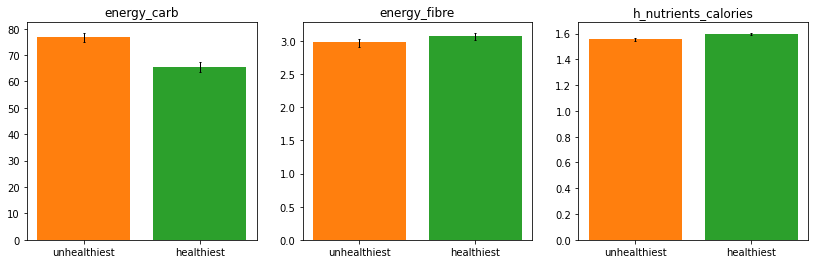

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(14, 4))

for i, f in enumerate(features):
    lowest_err = st.t.interval(0.95, len(lowest.loc[f])-1, loc=lowest.loc[f].mean(), scale=st.sem(lowest.loc[f]))
    lowest_err = [lowest.loc[f].mean() - lowest_err[0], lowest_err[1] - lowest.loc[f].mean()]
    highest_err = st.t.interval(0.95, len(highest.loc[f])-1, loc=highest.loc[f].mean(), scale=st.sem(highest.loc[f]))
    highest_err = [highest.loc[f].mean() - highest_err[0], highest_err[1] - highest.loc[f].mean()]

    axs[i].bar([0, 1], [lowest.loc[f].mean(), highest.loc[f].mean()], color=['tab:orange', 'tab:green'],
              yerr = [lowest_err, highest_err], error_kw=dict(lw=1, capsize=1, capthick=1))
    axs[i].set_xticks([0, 1])
    axs[i].set_xticklabels(['unhealthiest', 'healthiest'])
    axs[i].set_title(f)

We obtain a realistic first score. The error bars are obtained with a 95% confidence interval. The carbohydrates energy is higher for the unhealthiest areas. The diversity of nutrients and fibre energy are slightly higher for the healthiest areas. 

#### Method 2 : fit a linear regression on the obesity datasets with the most consumed f_food_categories features

In [42]:
features = ['f_fruit_veg', 'f_sweets', 'f_grains', 'f_dairy']

In [43]:
weights = pd.DataFrame(index = features, columns = indicators)

for label in indicators:
    weights[label],_ = find_weights(merged_borough, label)

prevalence_obese_reception
Training error : 0.000240, R2 : 0.154918
prevalence_obese_y6
Training error : 0.000894, R2 : 0.165841
f_obese
Training error : 12.755926, R2 : 0.412413
prevalence_overweight_reception
Training error : 0.000336, R2 : 0.204667
prevalence_overweight_y6
Training error : 0.001125, R2 : 0.204708
f_overweight
Training error : 8.032958, R2 : 0.165820


In [44]:
weights = weights.mean(axis = 1)

In [45]:
groceries_borough['score2'] = groceries_borough.apply(score, axis=1)
scaler = MinMaxScaler()
groceries_borough['score2'] = 1 - scaler.fit_transform(groceries_borough[['score2']].values.reshape(-1,1))

In [46]:
lowest = pd.DataFrame(groceries_borough[groceries_borough['score2'] <= groceries_borough['score2'].quantile(0.25)][features]).T
highest = pd.DataFrame(groceries_borough[groceries_borough['score2'] >= groceries_borough['score2'].quantile(0.75)][features]).T

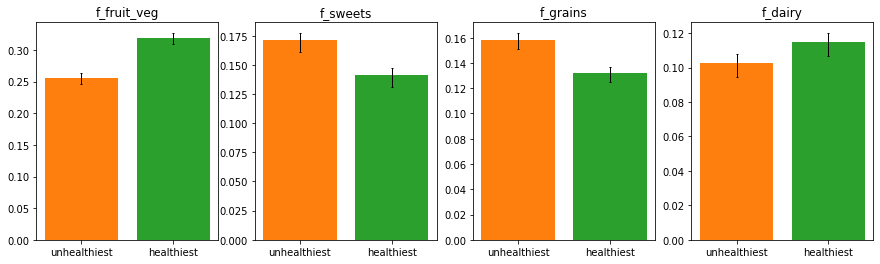

In [47]:
fig, axs = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False, figsize=(15, 4))

for i, f in enumerate(features):
    lowest_err = st.t.interval(0.95, len(lowest.loc[f])-1, loc=lowest.loc[f].mean(), scale=st.sem(lowest.loc[f]))
    lowest_err = [lowest.loc[f].mean() - lowest_err[0], lowest_err[1] - lowest.loc[f].mean()]
    highest_err = st.t.interval(0.95, len(highest.loc[f])-1, loc=highest.loc[f].mean(), scale=st.sem(highest.loc[f]))
    highest_err = [highest.loc[f].mean() - highest_err[0], highest_err[1] - highest.loc[f].mean()]
    
    axs[i].bar([0, 1], [lowest.loc[f].mean(), highest.loc[f].mean()], color=['tab:orange', 'tab:green'],
              yerr = [lowest_err, highest_err], error_kw=dict(lw=1, capsize=1, capthick=1))
    axs[i].set_xticks([0, 1])
    axs[i].set_xticklabels(['unhealthiest', 'healthiest'])
    axs[i].set_title(f)

We also obtain a realistic second score. The error bars are obtained with a 95% confidence interval. Healthier areas consume more dairy, fruit and vegetables. Unhealthier areas consume more sweets. However, the grains result is surprising.

#### Validation of the three scores and selection of the best one

In [48]:
merged_borough = pd.merge(merged_borough, groceries_borough[['area_id', 'score0', 'score1', 'score2']], on='area_id')

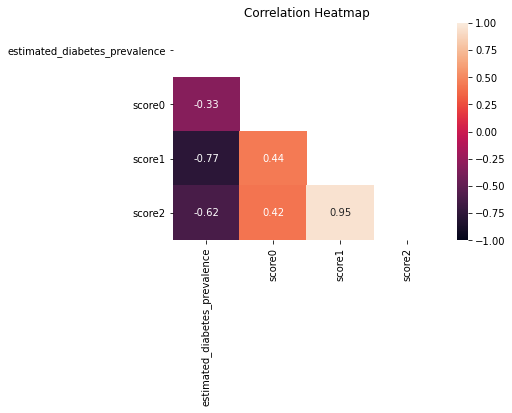

In [49]:
correlation_heatmap(merged_borough[['estimated_diabetes_prevalence', 'score0', 'score1', 'score2']])

We can see that score1 and score2 are highly correlated each other. They also have a negative correlation with diabetes and obesity. Score1 performs the least well. Thus, we choose to only select one for the next steps. As score1 has a biggest Spearman rank correlation coefficient than score2, we will only use score1 for our future analyses. 

### RQ4: How does this score relate to the economical situation of each borough?

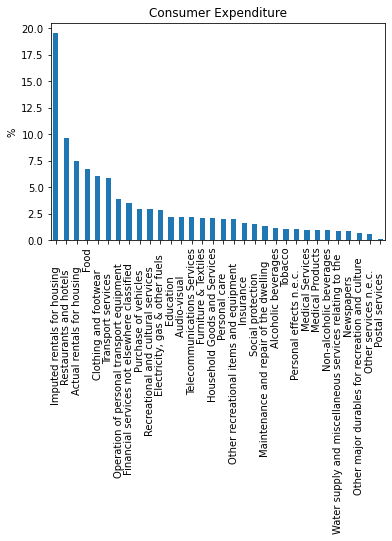

In [50]:
ax = consumer_expenditure.mean().sort_values(ascending = False).plot.bar()
ax.set_title('Consumer Expenditure')
ax.set_xlabel('')
ax.set_ylabel('%')
plt.show()

On average, food represents the 4st most spending activity of consumers.

Merge the economic data

In [51]:
groceries_poverty = pd.merge(groceries_borough, children_poverty, how = 'inner', on='area_id')

boroughs = mapping_code_to_borough.copy()
boroughs = pd.merge(boroughs, earnings, how='inner', on='Borough name')
groceries_earnings = pd.merge(groceries_borough, boroughs, how = 'inner', left_on='area_id', right_on='Borough Code')

boroughs = mapping_code_to_borough.copy()
boroughs = pd.merge(boroughs, consumer_expenditure[['Food', 'Medical Products', 'Medical Services']], how='inner', on='Borough name')
groceries_expenditure = pd.merge(groceries_borough, boroughs, how = 'inner', left_on='area_id', right_on='Borough Code')
groceries_expenditure.rename(columns={'Food':'food_expenditure'}, inplace=True)
groceries_expenditure['food_expenditure'] *= 100

In [52]:
merged_borough = pd.merge(merged_borough, groceries_poverty[['area_id', 'child_poverty']], on='area_id')
merged_borough = pd.merge(merged_borough, groceries_earnings[['area_id', 'earnings']], on='area_id')
merged_borough = pd.merge(merged_borough, groceries_expenditure[['area_id', 'food_expenditure', 'Medical Products', 'Medical Services']], on='area_id')

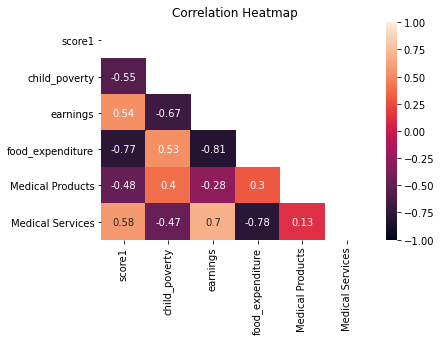

In [53]:
features = merged_borough[['score1', 'child_poverty', 'earnings', 'food_expenditure',
                           'Medical Products', 'Medical Services']]
correlation_heatmap(features)

In [54]:
correlation = pd.DataFrame(columns = ['feature1', 'feature2', 'R', 'p_value'])
for i in ['score1', 'child_poverty', 'earnings', 'food_expenditure',
                           'Medical Products', 'Medical Services']:
    for f in ['score1', 'child_poverty', 'earnings', 'food_expenditure',
                           'Medical Products', 'Medical Services']:
        corr = stats.spearmanr(merged_borough[i], merged_borough[f])
        corr_data = pd.DataFrame([[i, f, corr[0], corr[1]]], columns = ['feature1', 'feature2', 'R', 'p_value'])
        if (corr[1] < 0.05 and i!=f):
            correlation = correlation.append(corr_data, ignore_index = True)
df1 = pd.DataFrame(np.sort(correlation[['feature1','feature2']], axis=1))
correlation = correlation[~df1.duplicated()]
correlation

,feature1,feature2,R,p_value
0,score1,child_poverty,-0.548419,0.006737
1,score1,earnings,0.535573,0.008444
2,score1,food_expenditure,-0.769763,0.000018
3,score1,Medical Products,-0.475296,0.021902
4,score1,Medical Services,0.583004,0.003504
6,child_poverty,earnings,-0.673913,0.000422
7,child_poverty,food_expenditure,0.532609,0.008885
8,child_poverty,Medical Services,-0.467391,0.024528
11,earnings,food_expenditure,-0.806324,0.000003
12,earnings,Medical Services,0.699605,0.000203


A healthier diet is positively correlated with earnings and negatively correlated with child poverty as expected. However, it is negatively correlated with food_expenditure. We can see that the earnings and food expenditures are negatively correlated as well. This shows that the wealthier is a household, the more it can afford to spend on other less vital spendings than food. This is in accordance with the Engel's law, an observation in economics which states that as the income increases, the proportion of income spent on food falls, even if the absolute expenditure on food rises.
As for the medical expenses, the medical services consumption is positively correlated with earnings but negatively correlated with food_expenditure.

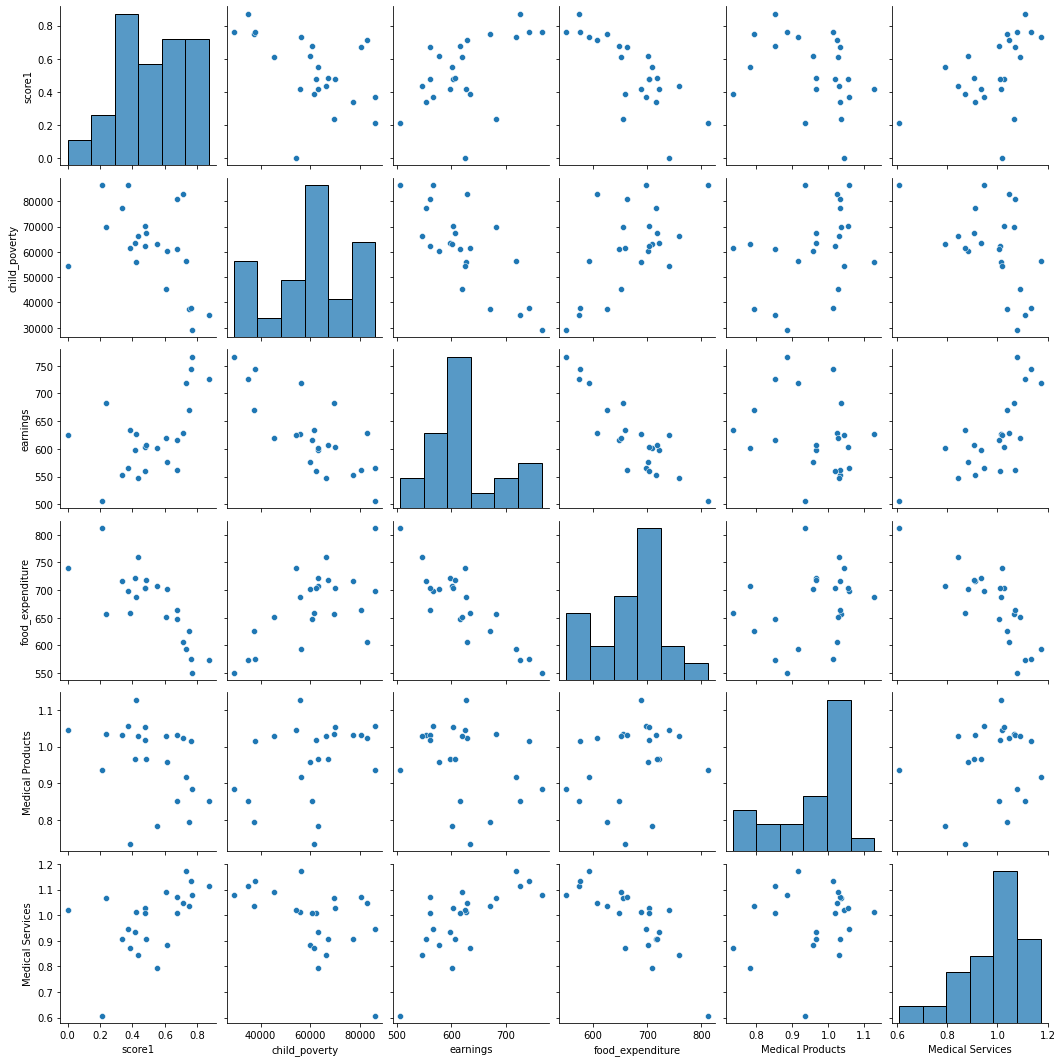

In [55]:
sns.pairplot(features)

In [56]:
features = ['child_poverty', 'earnings', 'food_expenditure', 'Medical Services', 'Medical Products']
weights, prediction = find_weights(merged_borough, 'score1')

score1
Training error : 0.013010, R2 : 0.697927


We obtain a good performance for our final model with a $R^2$ of 0.68.